In [100]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("FNMA", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,4.05,3.91,3.98,3.93,5226600,3.93
2017-01-09,4.00,3.93,3.96,3.96,5738200,3.96
2017-01-10,3.96,3.91,3.95,3.94,3165600,3.94
2017-01-11,3.95,3.84,3.92,3.92,3839900,3.92
2017-01-12,3.96,3.88,3.91,3.89,2092800,3.89


In [101]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

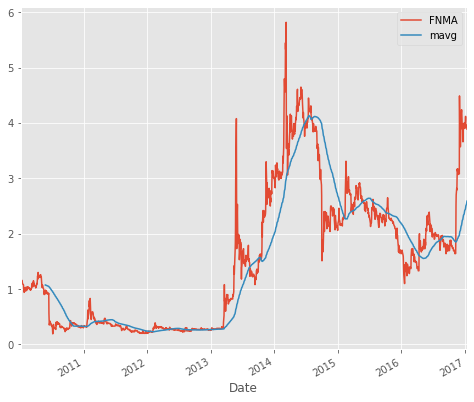

In [103]:
close_px.plot(label='FNMA')
mavg.plot(label='mavg')
plt.legend()

In [104]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [105]:
import math 
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
#X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X_train = X[:-forecast_out]
X_test = X[:forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y_train = y[:-forecast_out]
y_test = y[:forecast_out]

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [107]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

C:\Users\Natasha Crosby\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.07536e-35): result may not be accurate.
  overwrite_a=True).T
C:\Users\Natasha Crosby\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.87744e-52): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [108]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [109]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
#('The linear regression confidence is ', 0.96399641826551985)
#('The quadratic regression 2 confidence is ', 0.96492624557970319)
#('The quadratic regression 3 confidence is ', 0.9652082834532858)
('The knn regression confidence is ', 0.92844658034790639)



('The knn regression confidence is ', 0.9284465803479064)

In [110]:

forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan
#result
forecast_set

array([2.25      , 1.29500003, 0.855     , 1.75000006, 1.33999997,
       1.22000003, 0.33500001, 1.25000004, 2.34500003, 3.61500001,
       1.90999997, 0.77999997, 2.73499995, 1.79499997, 0.74999999,
       1.92999995, 1.35500002, 1.28      ])

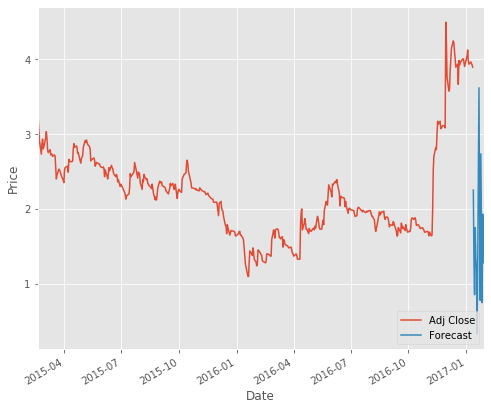

In [111]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()